In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def confusion_matrix(data,tree,class_label='CLASS'):
    #or set?
    #binary_problem
    positive_value = '>50K'
    negative_value = '<=50K'
    #[Actual >50k and predicted >50k, Actual 50k but predicted <50k][Actual<50k and predicted <50k, Actual <50k and predicted >50k]
    confusion_matrix=[[0,0],[0,0]]
    queries = data.iloc[:, :-1].to_dict(orient="records")
    for i in range(len(data)):
        prediction = tree_utils.predict(queries[i], tree)
        if data[class_label][i] == '>50K' and prediction == '>50K':
            #true_positive
            confusion_matrix[0][0]+=1
        if data[class_label][i] == '<=50K' and prediction == '<=50K':
            #true negative
            confusion_matrix[1][1]+=1
        if data[class_label][i] == '<=50K' and prediction == '>50K':
            #false_negative
            confusion_matrix[1][0]+=1
        if data[class_label][i] == '>50K' and prediction == '<=50K':
            #false_positive
            confusion_matrix[0][1]+=1
            
    print('data len=', len(data))
    return confusion_matrix

In [4]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [5]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
    print("confusion-matrix:", confusion_matrix(testing_data, trained_tree))
    print("confusion-matrix-training:", confusion_matrix(training_data, trained_tree))
    
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print("confusion-matrix:", confusion_matrix(testing_data, pruned_trained_tree))
    print("confusion-matrix-training:", confusion_matrix(training_data, pruned_trained_tree))
    print('\n')
#     return pruned_trained_tree
    pprint(pruned_trained_tree)
#     pprint(pruned_trained_tree)

In [6]:
# default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
#                       dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
#                       dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]
# default_heuristics = [dt_heur.mdl_simple,  dt_heur.j_measure]
default_heuristics = [dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Adult Dataset

## Data preparation

In [7]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,29,Private,178551,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
1,26,Private,137367,Some-college,10,Never-married,Handlers-cleaners,Other-relative,Asian-Pac-Islander,Male,0,0,44,Philippines,<=50K
2,37,Local-gov,108320,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,45,United-States,>50K
3,40,Private,130834,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,19,Private,475028,HS-grad,9,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K


In [8]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week', 'native-country' ,'CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,29,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K
1,26,Private,Some-college,10,Never-married,Handlers-cleaners,Other-relative,Asian-Pac-Islander,Male,44,Philippines,<=50K
2,37,Local-gov,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,45,United-States,>50K
3,40,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K
4,19,Private,HS-grad,9,Never-married,Sales,Own-child,White,Female,20,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,24,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,35,United-States,<=50K
32557,45,Private,10th,6,Divorced,Sales,Not-in-family,White,Female,40,United-States,<=50K
32558,24,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,Black,Male,30,United-States,<=50K
32559,44,Private,Some-college,10,Separated,Prof-specialty,Unmarried,Black,Female,40,United-States,<=50K


In [9]:
adult_dataset.dropna(how='any', axis=0)
indexNames = adult_dataset[(adult_dataset['workclass'] == '?') | (adult_dataset['education'] == '?') | (adult_dataset['marital-status'] == '?') | (adult_dataset['occupation'] == '?') | (adult_dataset['relationship'] == '?') | (adult_dataset['race'] == '?') | (adult_dataset['sex'] == '?') | (adult_dataset['native-country'] == '?') ].index
# print(indexNames)
adult_dataset.drop(indexNames, inplace=True)
adult_dataset.head()
adult_dataset.reset_index(inplace=False)
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,29,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K
1,26,Private,Some-college,10,Never-married,Handlers-cleaners,Other-relative,Asian-Pac-Islander,Male,44,Philippines,<=50K
2,37,Local-gov,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,45,United-States,>50K
3,40,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K
4,19,Private,HS-grad,9,Never-married,Sales,Own-child,White,Female,20,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,24,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,35,United-States,<=50K
32557,45,Private,10th,6,Divorced,Sales,Not-in-family,White,Female,40,United-States,<=50K
32558,24,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,Black,Male,30,United-States,<=50K
32559,44,Private,Some-college,10,Separated,Prof-specialty,Unmarried,Black,Female,40,United-States,<=50K


### Adult 70%

<=50K    10586
>50K      3489
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

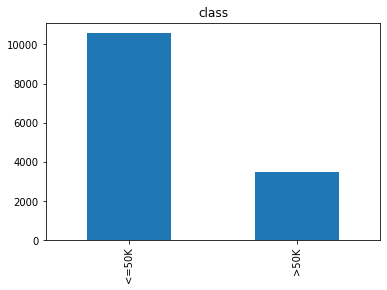

In [10]:
adult_set_for_training70, adult_testing70 = data_utils.data_split(adult_dataset, 70)
adult_training70, adult_validation70 = data_utils.split_training_data_for_pruning(adult_set_for_training70)

print(adult_training70['CLASS'].value_counts())
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

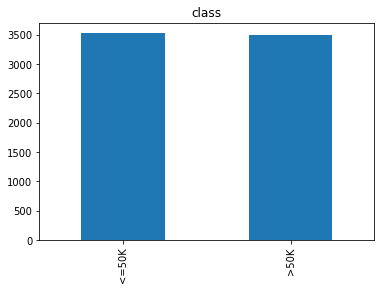

In [11]:
resampling_adult70 = adult_training70.copy()
less_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '<=50K']
more_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '>50K'] 

less_50k_part_downsampled70 = resample(less_50k_part70, 
                                 replace=False,    
                                 n_samples=3532)

# Combine minority class with downsampled majority class
balanced_adult_training70 = pd.concat([less_50k_part_downsampled70, more_50k_part70])
balanced_adult_training70 = balanced_adult_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training70 = balanced_adult_training70.sample(frac=1).reset_index(drop=True)

adult_training70 = balanced_adult_training70.copy()
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 80%

<=50K    12088
>50K      3997
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

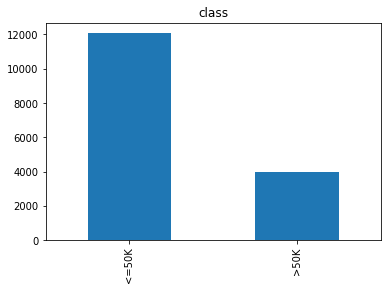

In [12]:
adult_set_for_training80, adult_testing80 = data_utils.data_split(adult_dataset, 80)
adult_training80, adult_validation80 = data_utils.split_training_data_for_pruning(adult_set_for_training80)

print(adult_training80['CLASS'].value_counts())
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

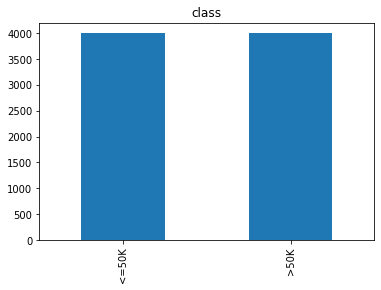

In [13]:
resampling_adult80 = adult_training80.copy()
less_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '<=50K']
more_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '>50K'] 

less_50k_part_downsampled80 = resample(less_50k_part80, 
                                 replace=False,    
                                 n_samples=4002)

# Combine minority class with downsampled majority class
balanced_adult_training80 = pd.concat([less_50k_part_downsampled80, more_50k_part80])
balanced_adult_training80 = balanced_adult_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training80 = balanced_adult_training80.sample(frac=1).reset_index(drop=True)

adult_training80 = balanced_adult_training80.copy()
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 90%

<=50K    13615
>50K      4481
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

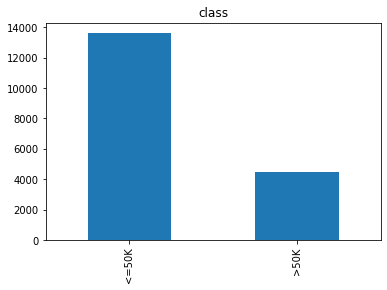

In [14]:
adult_set_for_training90, adult_testing90 = data_utils.data_split(adult_dataset, 90)
adult_training90, adult_validation90 = data_utils.split_training_data_for_pruning(adult_set_for_training90)

print(adult_training90['CLASS'].value_counts())
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

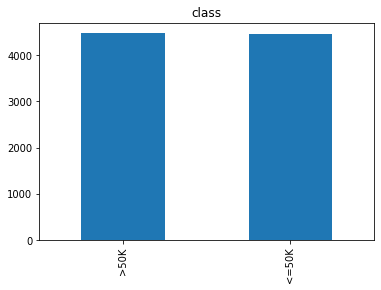

In [15]:
resampling_adult90 = adult_training90.copy()
less_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '<=50K']
more_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '>50K'] 

less_50k_part_downsampled90 = resample(less_50k_part90, 
                                 replace=False,    
                                 n_samples=4469)

# Combine minority class with downsampled majority class
balanced_adult_training90 = pd.concat([less_50k_part_downsampled90, more_50k_part90])
balanced_adult_training90 = balanced_adult_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training90 = balanced_adult_training90.sample(frac=1).reset_index(drop=True)

adult_training90 = balanced_adult_training90.copy()
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [16]:
# train_tree_for_different_heuristics(adult_training70, adult_testing70, adult_validation70)

In [17]:
tree_pruned = train_tree_for_different_heuristics(adult_training80, adult_testing80, adult_validation80)

Before Pruning - heuristic = mdl_simple
Accuracy for: testing 74.64% | training 79.78% | levels 38 | leafs 133
data len= 6033
confusion-matrix: [[1276, 239], [1240, 3227]]
data len= 7999
confusion-matrix-training: [[3402, 595], [1022, 2980]]
After Pruning:
Accuracy for: testing 81.12% | training 70.36% | levels 4 | leafs 3
data len= 6033
confusion-matrix: [[711, 813], [326, 4183]]
data len= 7999
confusion-matrix-training: [[1928, 2069], [302, 3700]]


{<education(-14.11)>: 10th[158] 11th[215] 12th[70] 1st-4th[26] 5th-6th[52] 7th-8th[124] 9th[85] Assoc-acdm[265] Assoc-voc[377] Bachelors[1655] Doctorate[170] HS-grad[2290] Masters[643] Preschool[5] Prof-school[234] Some-college[1630] : {'Bachelors,Assoc-voc,Masters,Assoc-acdm,Prof-school,Doctorate': {<relationship(-7.67)>: Husband[1982] Not-in-family[738] Other-relative[28] Own-child[150] Unmarried[198] Wife[248] : {'Husband,Wife': '>50K',
                                                                                                    

In [18]:
# train_tree_for_different_heuristics(adult_training90, adult_testing90, adult_validation90)

In [19]:
print(tree_pruned)

None


In [20]:
adult_training80[adult_training80['occupation']=='?']

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
